# Case Study 7 - Produce farm zone map
## Description 
As a grower, I want to analyse my yield maps and farm data, so I can zone up my farm based on site variability. 
## Case Breakdown 
- **Actors:** Grower
- **Goals:** Customized needs for Grower
- **Scope** Local,Paddock-Scale
## Generalised case
I want to analyse a suite of spatial variables across a site so I can derive a classification of areas by similarity.
## Comparable cases
- I want to combine a suite of environmental variables, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5) and soils (pH, N, K, structure) for N (e.g. 50) candidate sites and then select derive a classification for each subunit based on a clustering algorithm.
## Stakeholders 
- **Name:** Tom Bishop
- **Contact:** thomas.bishop@sydney.edu.au


## Data Sources
Use Llara-Campey data including yield values and soil maps to develop classification of farm area into contiguous zones of relatively self-similar productivity. Variables should include the minimum zone area and the maximum number of zone classes to return.

This notebook can be delivered as a tool into which the user can load their own data in the form of spreadsheets containing points and associated values for the variables to take into account in the analysis. The requirement is either for comprehensive (raster) coverage for the area or of a set of point-based measurements for each variable (in which case a simple kriging or mesh interpolation will be applied).

### Generating STAC records from config files

In [1]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core import StacCollectionConfig, StacSerialiser
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

parent_path = Path().cwd()
# Scenario 1
configs = [
    parent_path / "llara_point_config.json",
    parent_path / "llara_shape_config.json",
    parent_path / "scenario_1_config.json",
]
output_path = parent_path / "scenario_1"
collection_config = StacCollectionConfig(id="Collection")

# Serialising STAC records
with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(
        source_configs=configs, collection_config=collection_config, pool=pool
    )
    serialiser = StacSerialiser(generator, output_path.as_posix())
    serialiser()

2025-05-22T15:50:29-stac_generator.core.point.generator - INFO - Reading point asset: soil_measurement
2025-05-22T15:50:29-stac_generator.core.vector.generator - INFO - Reading vector asset: L3Boundary
2025-05-22T15:50:29-stac_generator.core.vector.generator - INFO - Reading vector asset: L1Boundary
2025-05-22T15:50:29-stac_generator.core.vector.generator - INFO - Reading vector asset: L4Boundary
2025-05-22T15:50:29-stac_generator.core.point.generator - INFO - Reading point asset: L1_2017_wheat
2025-05-22T15:50:29-stac_generator.core.point.generator - INFO - Reading point asset: L3_2017_wheat
2025-05-22T15:50:29-stac_generator.core.point.generator - INFO - Reading point asset: L4_2017_wheat
2025-05-22T15:50:29-stac_generator.core.base.generator - INFO - successfully save collection Collection to /home/harry/CodingProject/mccn-case-studies/Case 7/scenario_1


### Loading raw data using the MCCN Engine

In [2]:
# Loading in data cube
from mccn.client import MCCN

client = MCCN(endpoint=output_path / "collection.json", shape=(100, 100))
raw_ds = client.load()

In [3]:
raw_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 2, y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -30.26 -30.26 -30.26 ... -30.29 -30.29 -30.29
  * x            (x) float64 800B 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 16B 2016-01-01 2017-01-01
Data variables:
    L1Boundary   (time, y, x) int8 20kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L3Boundary   (time, y, x) int8 20kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L4Boundary   (time, y, x) int8 20kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    Clay         (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    EC           (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Sand         (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pH           (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Silt         (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GammaK       (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ECa          (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    moisture     (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    yield_t_ha   (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

### Preprocessing - Combining dates 

Our dataset has two time periods - 2016, 2017. The soil variables were collected in 2016 and the yield data collected in 2017. For convenience, we will assume that the soil measurements in 2016 are still valid in 2017 and remove the time dimension of the cube.

In [ ]:
axis = {1: ["yield_t_ha"]}
# Repeat and extract to 2016 for convenience
proc_ds = raw_ds.copy()
for idx, vars in axis.items():
    for var in vars:
        proc_ds[var].values = np.repeat(
            np.expand_dims(proc_ds[var].values[idx, :, :], 0), 2, axis=0
        )

# Slice 2016, selecting only relevant variables and removing time dimension
proc_ds = proc_ds[
    [
        # Boundary values
        "L1Boundary",
        "L3Boundary",
        "L4Boundary",
        # Predictors
        "pH",
        "EC",
        "Sand",
        "Silt",
        "Clay",
        "ECa",
        "GammaK",
        # Response
        "yield_t_ha",
    ]
].isel(time=0)

# Make a mask layer based on the values of L1, L3, L4 boundaries
# Note we also mask based on yield values
mask = proc_ds["L1Boundary"] + proc_ds["L3Boundary"] + proc_ds["L4Boundary"] + proc_ds["yield_t_ha"]

In [17]:
proc_ds

<xarray.Dataset> Size: 672kB
Dimensions:      (y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -30.26 -30.26 -30.26 ... -30.29 -30.29 -30.29
  * x            (x) float64 800B 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2016-01-01
Data variables:
    L1Boundary   (y, x) int8 10kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    L3Boundary   (y, x) int8 10kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    L4Boundary   (y, x) int8 10kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    pH           (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    EC           (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Sand         (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Silt         (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Clay         (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ECa          (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GammaK       (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    yield_t_ha   (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

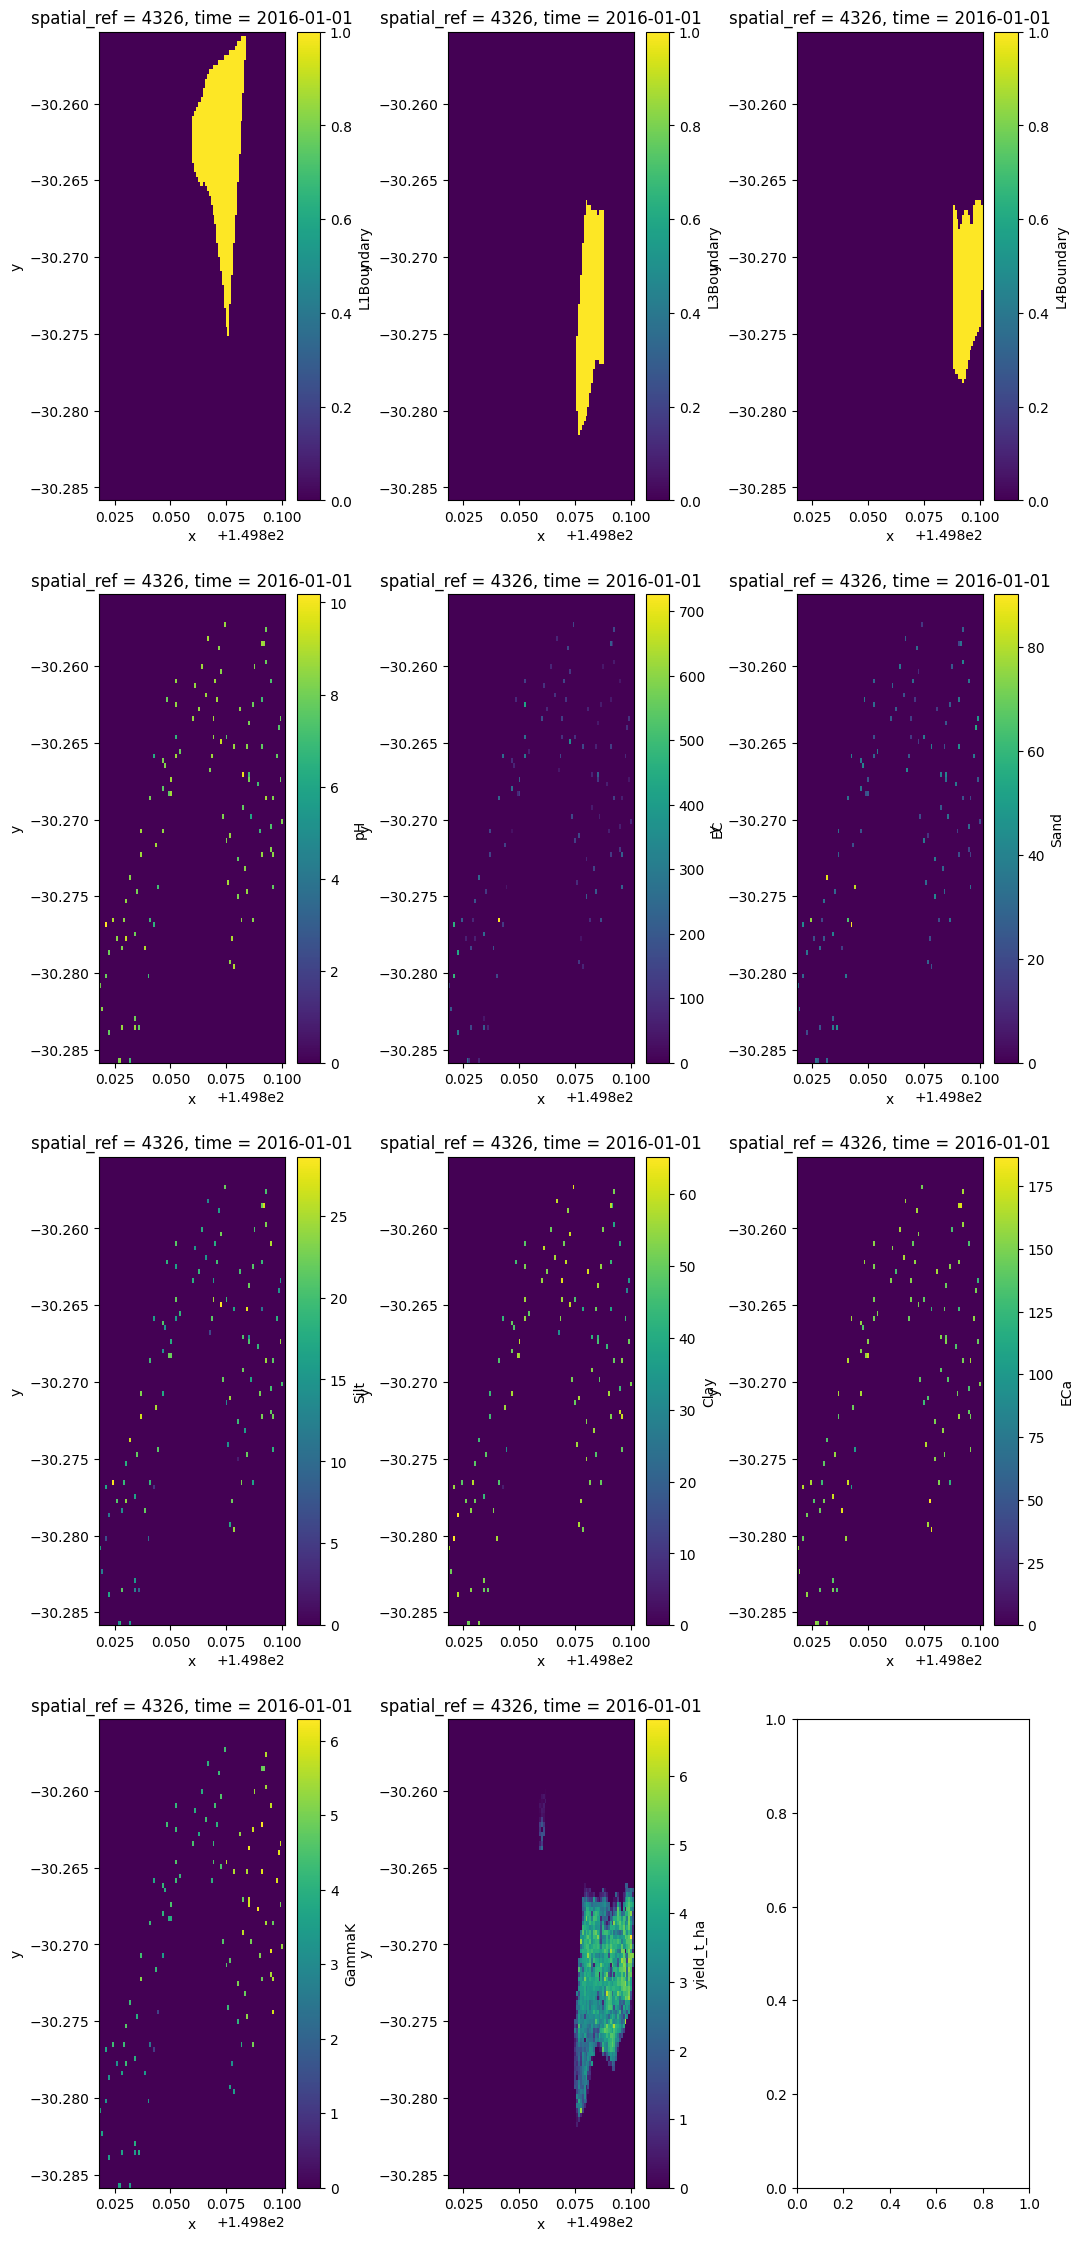

In [18]:
# Visualising variables
f, subplots = plt.subplots(4, 3, figsize=(12, 28), squeeze=True)
plt.subplots_adjust(wspace=0.5, hspace=0.2)  # Adjust the spacing
i, j = 0, 0
for var in proc_ds.data_vars.keys():
    proc_ds[var].plot(ax=subplots[j, i], x="x", y="y")
    i, j = (0, j + 1) if i == 2 else (i + 1, j)

### Processing - Applying Ordinary Krigging

In [46]:
import pykrige
import xarray as xr

krig_var = ["pH", "EC", "Sand", "Silt", "Clay", "ECa", "GammaK"]
for var in krig_var:
    grid = np.array(
        [
            (proc_ds["x"].values[i], proc_ds["y"].values[j], proc_ds[var].values[i, j])
            for i in range(len(proc_ds["x"]))
            for j in range(len(proc_ds["y"]))
            if proc_ds[var].values[i, j] > 0
        ]
    )
    if len(grid) != 0:
        model = pykrige.ok.OrdinaryKriging(
            grid[:, 0], grid[:, 1], grid[:, 2], variogram_function="linear", exact_values=False,
        )
        krigged_var, _ = model.execute("grid", proc_ds["x"].values, proc_ds["y"].values)
        proc_ds["Krigged_" + var] = xr.DataArray(
            krigged_var.data, coords={"y": proc_ds["y"], "x": proc_ds["x"]}
        )
        proc_ds["Krigged_" + var] = proc_ds["Krigged_" + var].where(mask.squeeze(), 0)


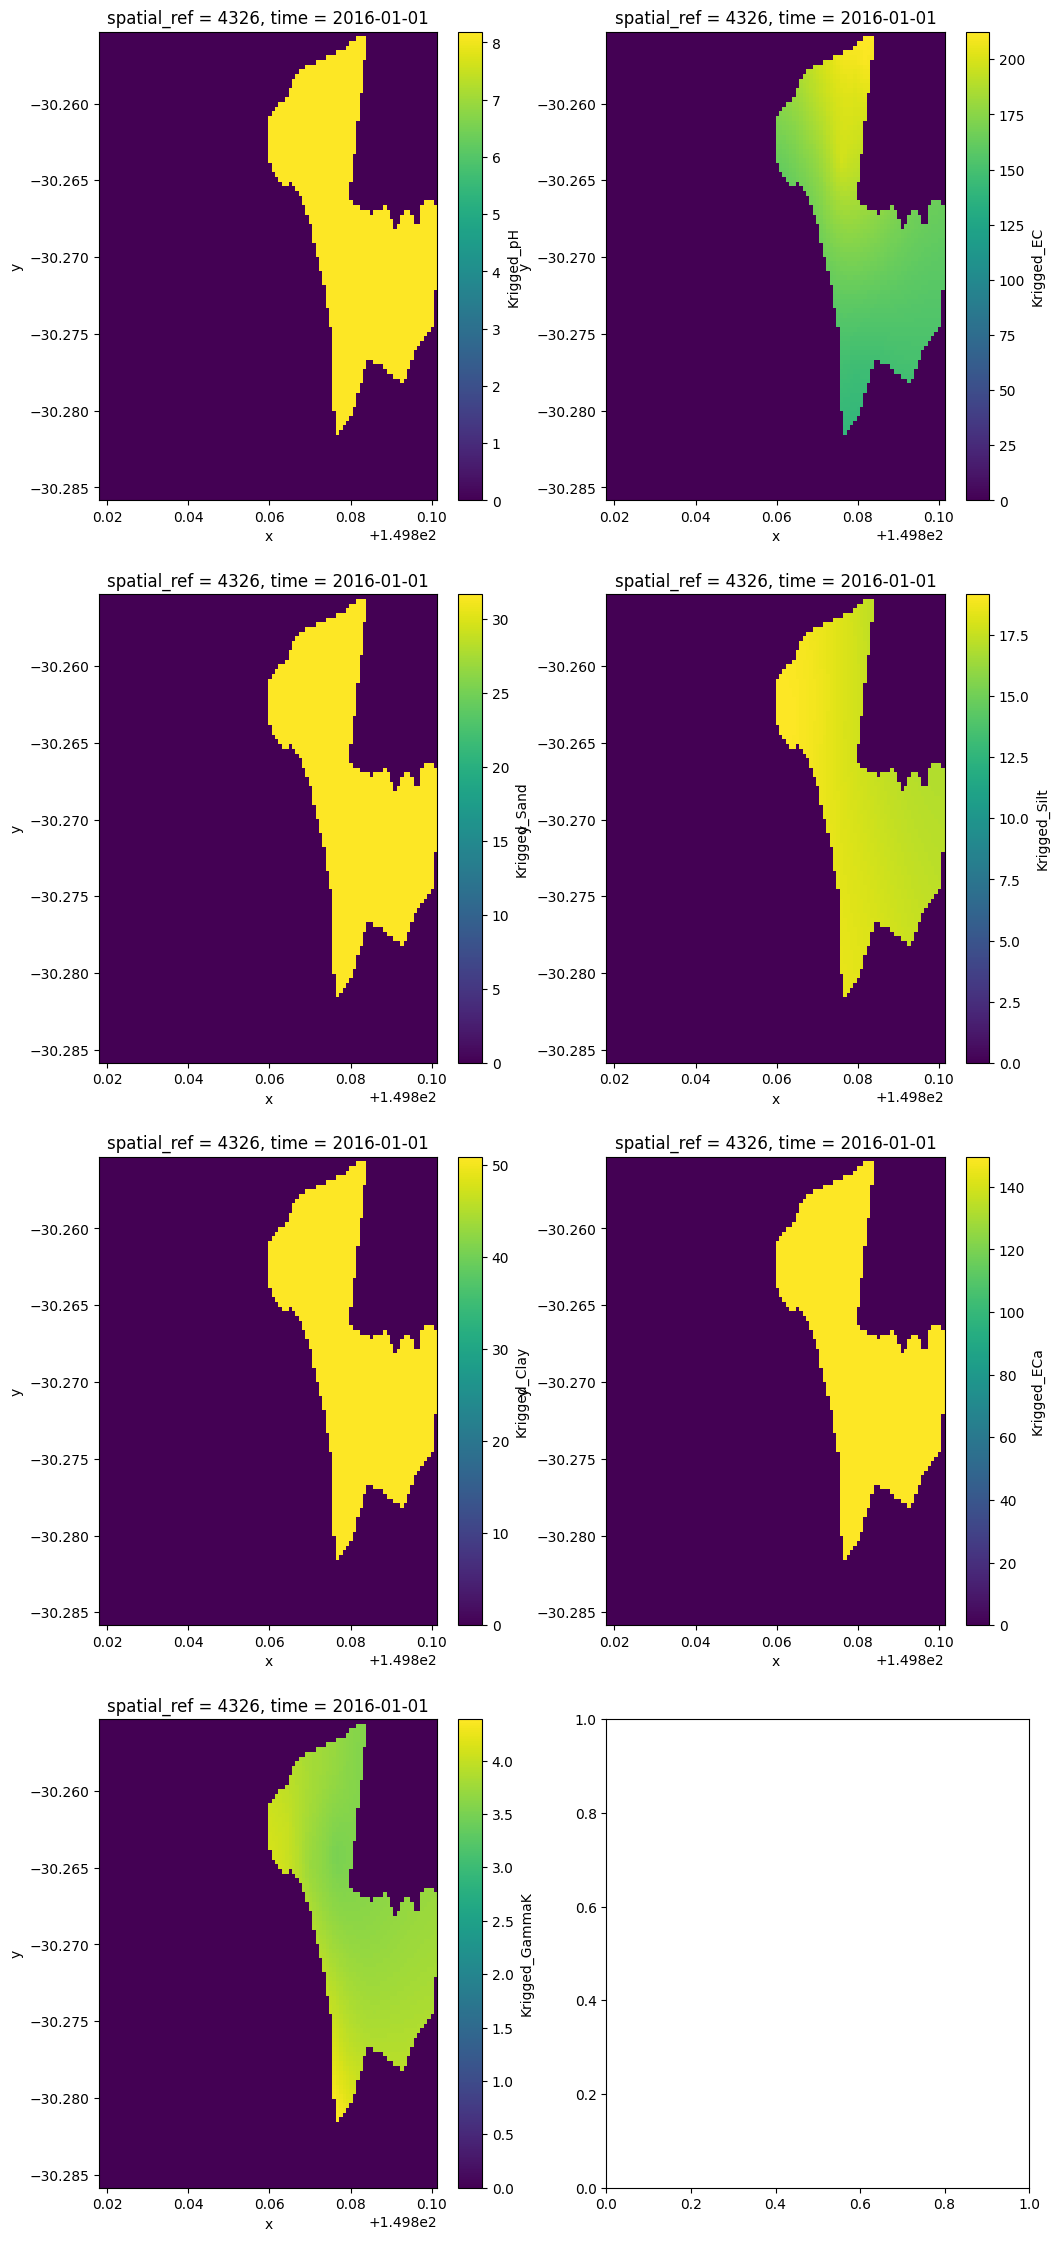

In [47]:
plot_vars = ["Krigged_" + var for var in krig_var]

# Visualising variables
f, subplots = plt.subplots(4, 2, figsize=(12, 28), squeeze=True)
i, j = 0, 0
for var in plot_vars:
    proc_ds[var].plot(ax=subplots[j, i], x="x", y="y")
    i, j = (0, j + 1) if i == 1 else (i + 1, j)

### Perform field zoning based on yield data

We will be using the [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) algorithm for clustering Llara into different management zones. We first try clustering based on yield data alone

In [39]:
from sklearn.cluster import KMeans

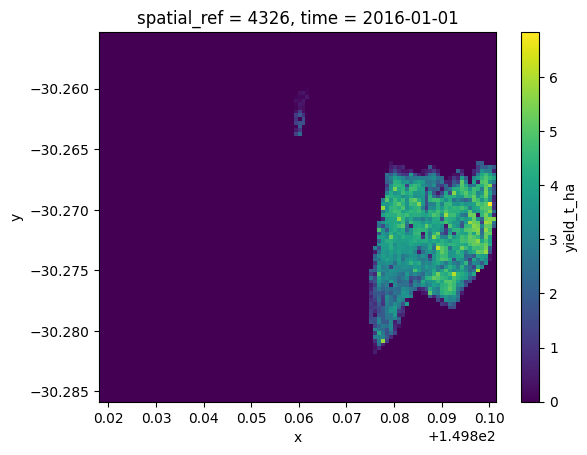

In [40]:
# Plotting Yield layer data
proc_ds["yield_t_ha"].plot(x="x", y="y")

### Perform field zoning using soil measurements

Since soil data is sparse, we will only perform zoning based on overlapping locations

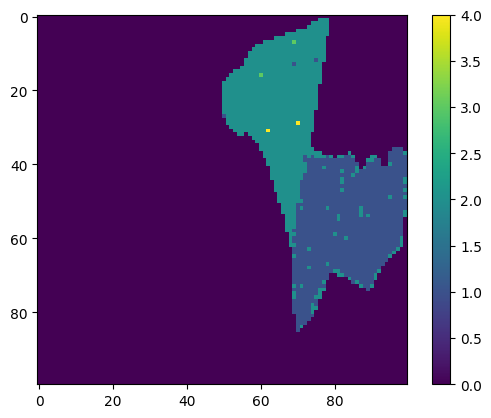

In [41]:
variables = proc_ds[
    [
        "Krigged_pH",
        "Krigged_EC",
        "Krigged_Sand",
        "Krigged_Silt",
        "Krigged_Clay",
        "Krigged_ECa",
        "Krigged_GammaK",
        "yield_t_ha",
    ]
]
x_grid, y_grid = np.meshgrid(proc_ds["x"].values, proc_ds["y"].values, indexing="ij")
x_val = x_grid.reshape(-1, 1) - x_grid.mean() / x_grid.std()
y_val = y_grid.reshape(-1, 1) - y_grid.mean() / y_grid.std()
X = [x_val, y_val]

# Preprocess variables
for var in variables:
    values = variables[var].values[:, :].reshape(-1, 1)
    # Perform standard scaling to avoid scaling influence
    mean = values[values != 0].mean()
    std = values[values != 0].std()
    X.append((values - mean) / std)
X = np.concat(X, axis=-1)

# Cluster
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(X)
plt.imshow(cluster_labels.reshape(100, 100))
plt.colorbar()
plt.show()

### Using GMM

In [42]:
features_df = proc_ds.to_dataframe().reset_index()
features_df = features_df.loc[
    :,
    [
        "y",
        "x",
        "Krigged_pH",
        "Krigged_EC",
        "Krigged_Sand",
        "Krigged_Silt",
        "Krigged_Clay",
        "Krigged_ECa",
        "Krigged_GammaK",
        "yield_t_ha",
    ],
]
features_df.rename(columns={"y": "lat", "x": "lon"}, inplace=True)
features_position = features_df.loc[:, ["lat", "lon"]]
features_X = features_df.loc[
    :,
    [
        "Krigged_pH",
        "Krigged_EC",
        "Krigged_Sand",
        "Krigged_Silt",
        "Krigged_Clay",
        "Krigged_ECa",
        "Krigged_GammaK",
        "yield_t_ha",
    ],
]
for col in features_X.columns:
    mean = features_X[features_X[col] != 0][col].mean()
    std = features_X[features_X[col] != 0][col].std()
    features_X[col] = (features_X[col] - mean) / std

In [43]:
features_df.head()

,lat,lon,Krigged_pH,Krigged_EC,Krigged_Sand,Krigged_Silt,Krigged_Clay,Krigged_ECa,Krigged_GammaK,yield_t_ha
0,-30.255472,149.818460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-30.255472,149.819293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-30.255472,149.820127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-30.255472,149.820961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-30.255472,149.821794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from SpatialCluster.methods.GMM import GMM_Clustering

GMM_areas_to_points, GMM_clusters = GMM_Clustering(
    features_X,
    features_position,
    n_clusters=5,
    covariance_type="full",
    tol=1e-3,
    reg_covar=1e-6,
)

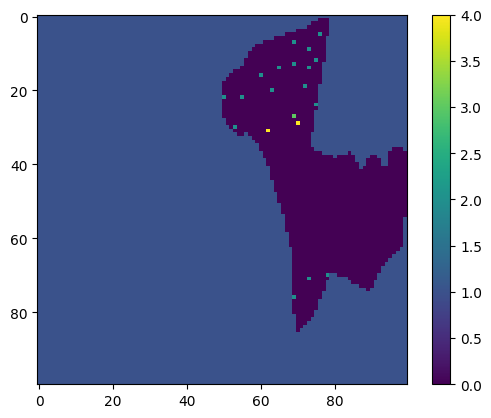

In [45]:
plt.imshow(GMM_clusters.reshape(100, 100))
plt.colorbar()
plt.show()

### Clean up

In [ ]:
import shutil

shutil.rmtree(output_path)